In [1]:
# for loading data
import numpy as np
import pandas as pd
import os
# for visualization
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'Arial'
import seaborn as sns

from scipy.stats import mannwhitneyu, ttest_ind
# for classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score

In [2]:
# 合并Gevers数据和HMP2数据

# HMP2
raw_rm_na = pd.read_excel('./RawData/HMP2/nonIBD vs IBD-remove_missing.xlsx', index_col=0).T
nonIBD_data = raw_rm_na.loc[raw_rm_na['Genus'] == 'nonIBD'].iloc[:, 1:]
# 'Lactobacillus' in nonIBD_data.columns.tolist()
IBD_data = raw_rm_na.loc[raw_rm_na['Genus'] != 'nonIBD'].iloc[:, 1:]  # UC & CD
nonIBD_data = nonIBD_data.loc[nonIBD_data.isna().sum(axis=1) < 100]
IBD_data = IBD_data.loc[IBD_data.isna().sum(axis=1) < 100]
print(nonIBD_data.shape, IBD_data.shape)

HMP2_data = pd.concat([nonIBD_data, IBD_data], axis=0)
HMP2_data['label'] = [0] * len(nonIBD_data) + [1] * len(IBD_data)
print(HMP2_data.shape)

# 注意：HMP2菌群丰度相加为1，与Gevers或者GMrepo合并时需乘以100

(42, 111) (97, 111)
(139, 112)


In [3]:
# load Gevers data
gevers_data = pd.read_excel('./RawData/Gevers/Gevers_remove_missing.xlsx', sheet_name='Sheet2')
# gevers_data.head()
# gevers_data.columns.tolist().index('Control')  # 394
cd_gevers_data = gevers_data.iloc[:, 3:393]
cd_gevers_data.index = gevers_data.iloc[:, 2].tolist()
cd_gevers_data = cd_gevers_data.T
cd_gevers_data = cd_gevers_data.loc[cd_gevers_data.isna().sum(axis=1) < 60]
print(cd_gevers_data.shape)
# cd_gevers_data.head(2)
ctl_gevers_data = gevers_data.iloc[:, 395:]
ctl_gevers_data.index = gevers_data.iloc[:, 2].tolist()
ctl_gevers_data = ctl_gevers_data.T
ctl_gevers_data = ctl_gevers_data.loc[ctl_gevers_data.isna().sum(axis=1) < 60]
print(ctl_gevers_data.shape)
# ctl_gevers_data.head(2)

Gevers_data = pd.concat([cd_gevers_data, ctl_gevers_data], axis=0)
Gevers_data.index = Gevers_data.index.map(lambda item: item.strip())
Gevers_data['label'] = [1] * len(cd_gevers_data) + [0] * len(ctl_gevers_data)
print(Gevers_data.shape)

(388, 69)
(38, 69)
(426, 70)


In [4]:
# merge
HMP2_data_new = np.empty((len(HMP2_data), Gevers_data.shape[1]), dtype=np.float32)
for i, col in enumerate(Gevers_data.columns.tolist()):
    if col in HMP2_data.columns.tolist():
        if col != 'label':
            HMP2_data_new[:, i] = np.array(HMP2_data[col].values, dtype=np.float32) * 100
        else:
            # label column no need for multiplying 100
            HMP2_data_new[:, i] = np.array(HMP2_data[col].values, dtype=np.int64)
    else:
        HMP2_data_new[:, i] = np.nan

HMP2_data_new_df = pd.DataFrame(HMP2_data_new, columns=Gevers_data.columns.tolist(), index=HMP2_data.index.tolist())

Gevers_HMP2_data = pd.concat([Gevers_data, HMP2_data_new_df], axis=0)
Gevers_HMP2_data.shape

(565, 70)

### New Logistic regression 

In [5]:
mark = Gevers_HMP2_data.columns.tolist().index('Lactobacillus')
mark

51

In [6]:
# using C=10, penalty='l1' as hyperparameters
def classification_kfold(all_data, seed, print_res=True):
    features = all_data.iloc[:, :-1].values
    labels = all_data.iloc[:, -1].values

    saved_data = all_data.copy()
    test_aucs = []
    roc_data = []
    weights_list = []
    # using StratifiedKFold
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    for i, (train_index, test_index) in enumerate(kf.split(features, labels)):
        train_x, test_x = features[train_index], features[test_index]
        train_y, test_y = labels[train_index], labels[test_index]
        split_details = ['train' if i in train_index else 'test' for i in range(len(features))]

        scaler = MinMaxScaler(feature_range=(0,1), clip=True)
        pipe = Pipeline([('impute', SimpleImputer(strategy='constant', fill_value=0.)), ('scaler', scaler)])
        X = pipe.fit_transform(train_x)
        test_X = pipe.transform(test_x)

        model = LogisticRegression(penalty='l1', C=10, solver='liblinear', random_state=seed, max_iter=1000)
        model.fit(X, train_y)
        
        logits = model.predict_proba(test_X)[:, 1]
        test_auc = roc_auc_score(test_y, logits)

        fpr, tpr, _ = roc_curve(test_y, logits)

        # feature weights
        weights = model.coef_[0]
        argsort_weights = weights.argsort()
        rank = list(argsort_weights).index(mark)
        if print_res:
            print(rank, weights[mark], test_auc)

        test_aucs.append(test_auc)
        weights_list.append(weights)
        roc_data.append((fpr, tpr))
        saved_data[f'{seed}_fold_{i}'] = split_details
    
    mean_weights = np.stack(weights_list).mean(axis=0)
    rank = mean_weights.argsort()
    if print_res:
        print(np.mean(test_aucs))
        print(list(rank).index(mark))

    return saved_data, roc_data, mean_weights, np.mean(test_aucs)

In [7]:
saved_data, roc_data, mean_weights, mean_auc = classification_kfold(Gevers_HMP2_data, seed=42, print_res=True)

0 -8.307584255909514 0.6556122448979592
0 -8.50077701290069 0.7576530612244897
1 -7.283965644854653 0.8163265306122449
0 -7.702925431534851 0.7755102040816327
0 -7.741489793638099 0.9107142857142858
0 -10.389008592865828 0.8229166666666667
0 -8.264145624224803 0.6953125
0 -8.734735330833061 0.7421875
0 -8.352939569168742 0.9010416666666666
0 -7.74827324202121 0.7916666666666667
0.7868941326530613
0


In [8]:
# save training and testing data
saved_data.to_csv('./model/Gevers_HMP2_train_test_data.csv')

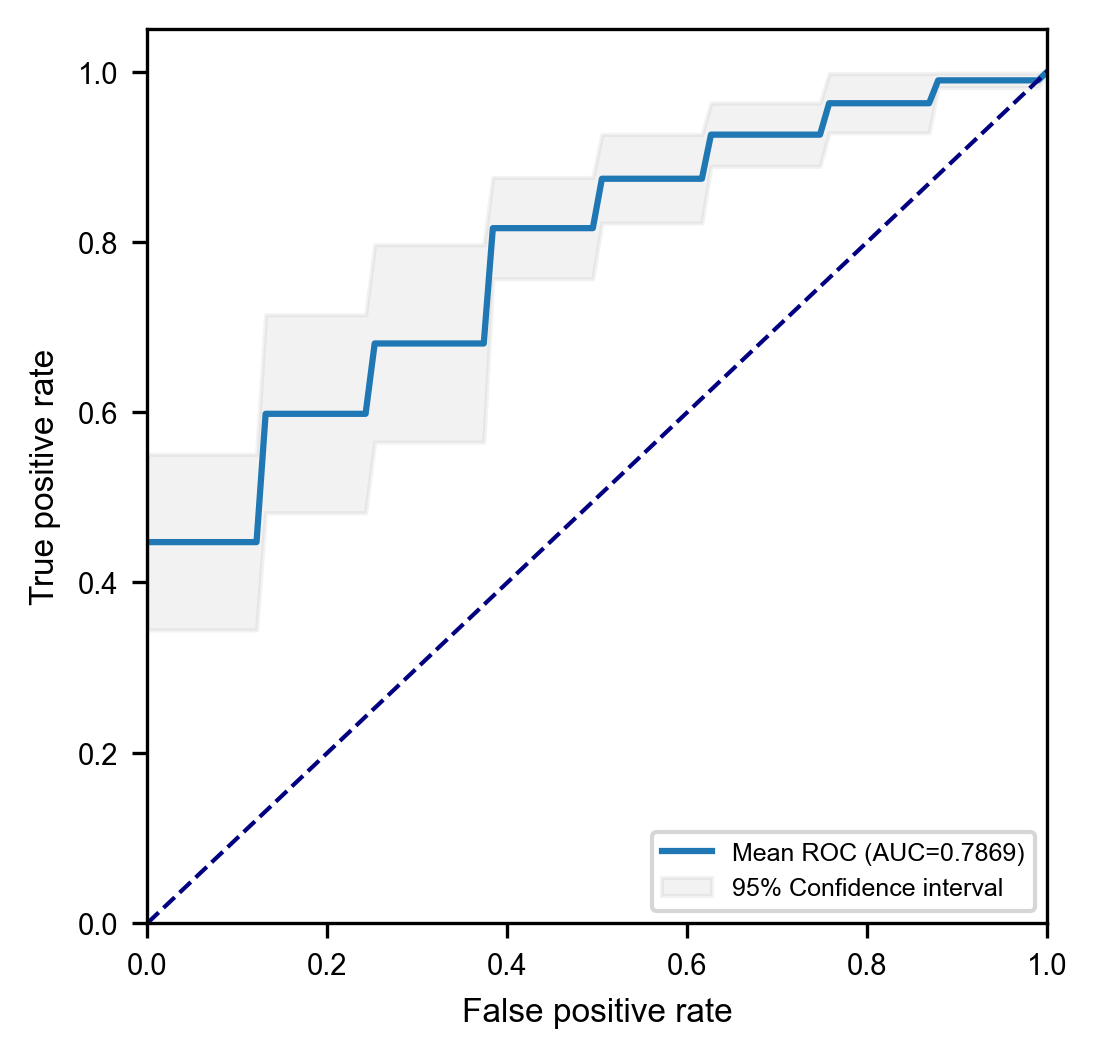

In [8]:
# plot
fig = plt.figure(figsize=(3.87,3.87), dpi=300)

# valid roc
ax = fig.add_subplot(111)
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in roc_data], axis=0)
# 计算置信区间
tpr_std = np.std([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in roc_data], axis=0)
tpr_upper = np.minimum(mean_tpr + 1.96 * tpr_std / np.sqrt(10), 1)
tpr_lower = mean_tpr - 1.96 * tpr_std / np.sqrt(10)
# 绘制平均ROC曲线
plt.plot(mean_fpr, mean_tpr, label='Mean ROC (AUC=0.7869)')
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.1, label='95% Confidence interval')

ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False positive rate', fontdict={'fontsize':8})
ax.set_ylabel('True positive rate', fontdict={'fontsize':8})
ax.tick_params(labelsize=7)
# ax.set_title('Receiver Operating Curve of Valid Dataset')
# ax.set_title('Receiver Operating Curve of Test Dataset')
ax.legend(fontsize=6, loc='lower right')

plt.savefig('./figures/Gevers_HMP2_mean_roc_curve.png', dpi=300)
plt.show()

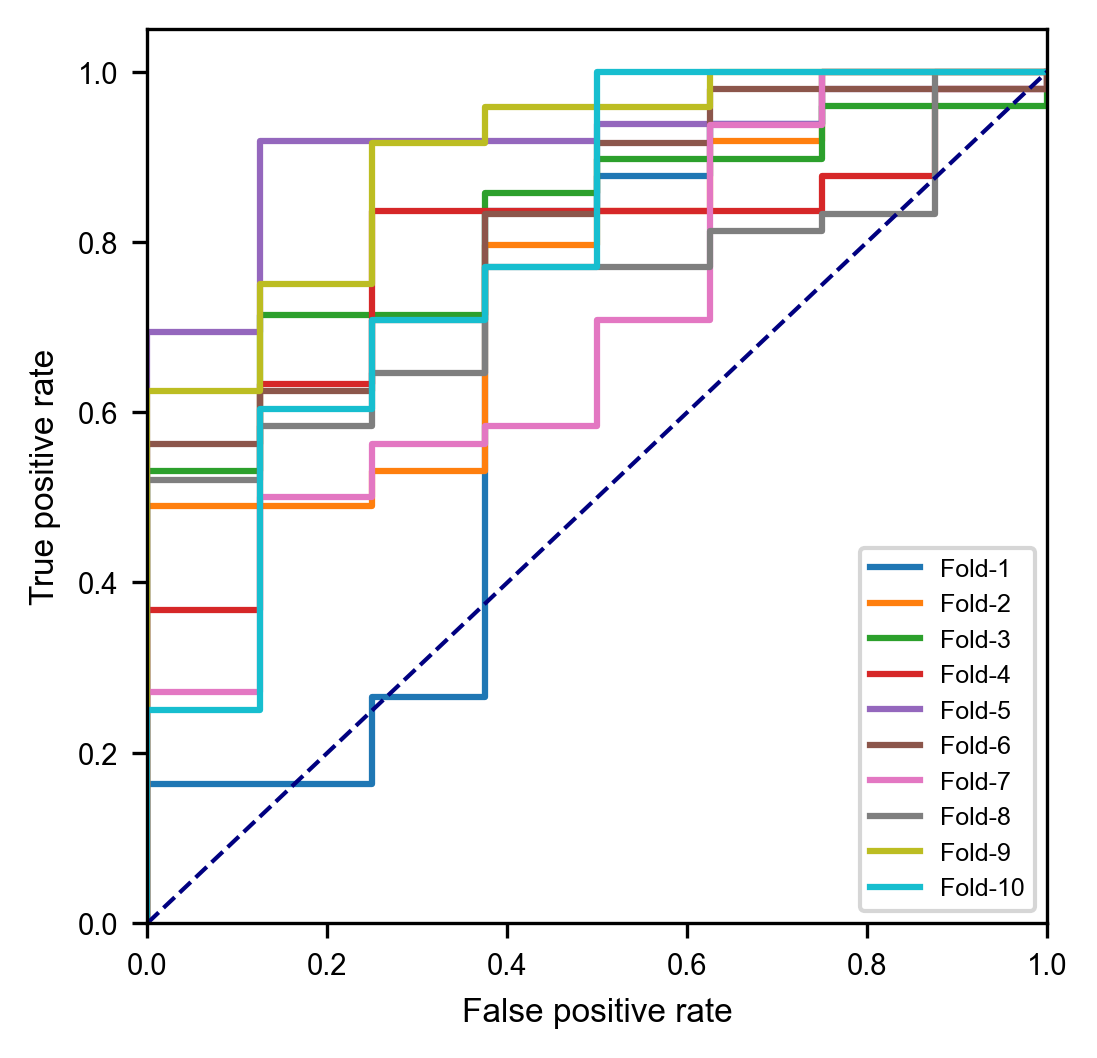

In [9]:
# plot
fig = plt.figure(figsize=(3.87,3.87), dpi=300)

# valid roc
ax = fig.add_subplot(111)
for k, d in enumerate(roc_data,1):
    ax.plot(d[0], d[1], label=f'Fold-{k}')  #  (auc={auc:.4f})
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False positive rate', fontdict={'fontsize':8})
ax.set_ylabel('True positive rate', fontdict={'fontsize':8})
ax.tick_params(labelsize=7)
# ax.set_title('Receiver Operating Curve of Valid Dataset')
# ax.set_title('Receiver Operating Curve of Test Dataset')
ax.legend(fontsize=6)

plt.savefig('./figures/Gevers_HMP2_roc_curve.png', dpi=300)
plt.show()

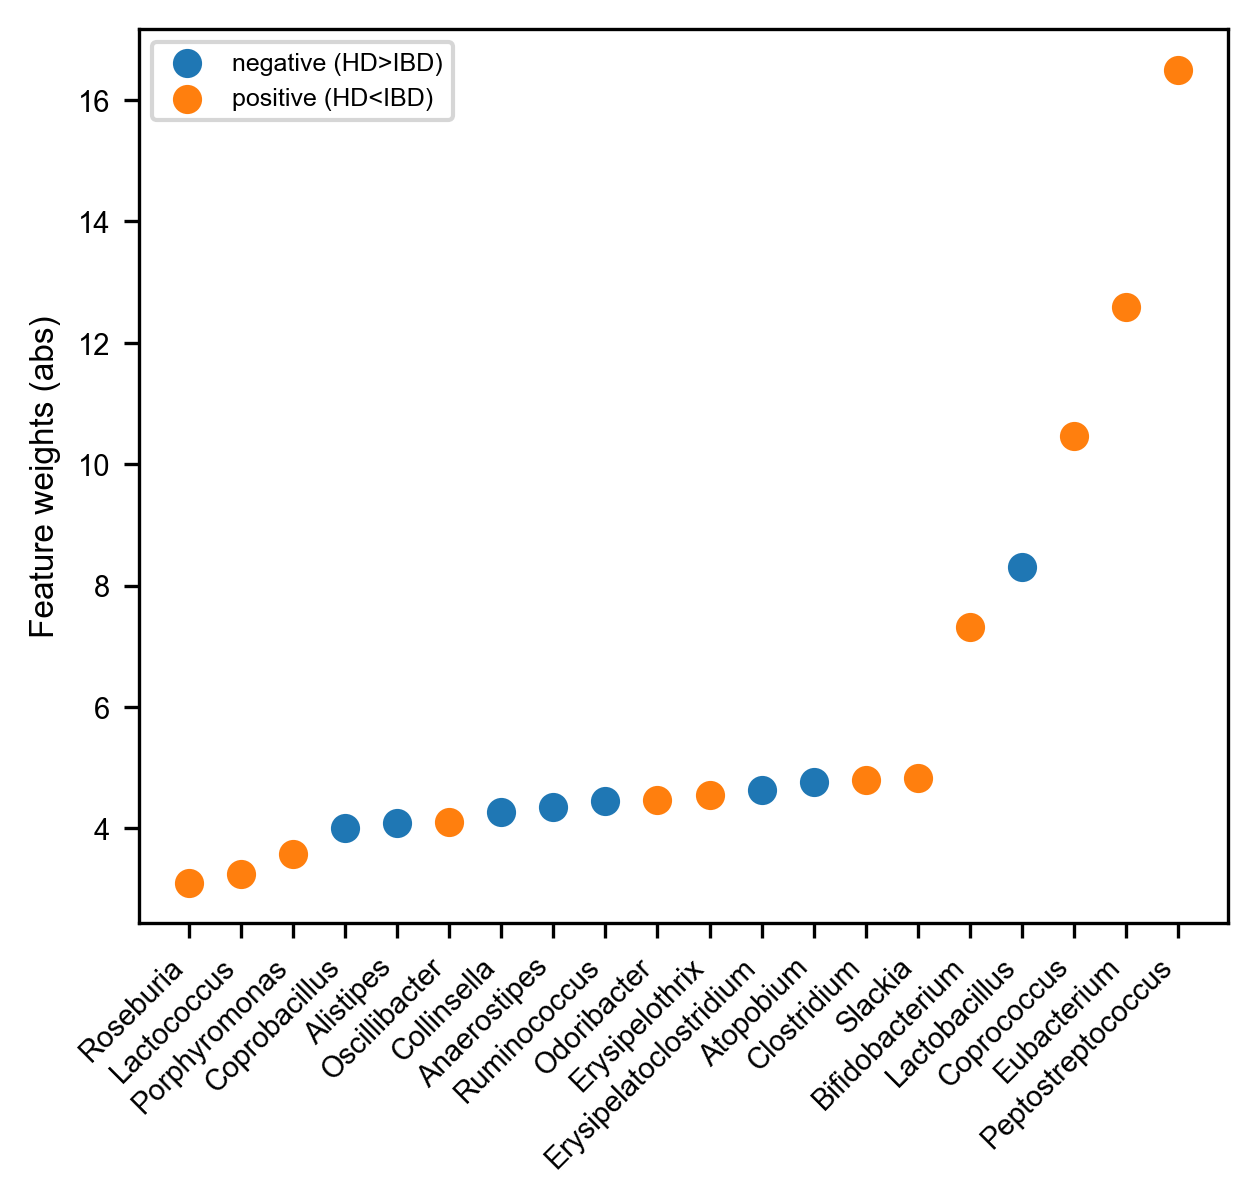

In [10]:
abs_rank = np.abs(mean_weights).argsort()

x_labels = []
pos_y, pos_x, neg_y, neg_x = [], [], [], []
for i, index in enumerate(abs_rank[-20:]):
    x_labels.append(Gevers_HMP2_data.columns.tolist()[index])
    if mean_weights[index] > 0:
        pos_y.append(mean_weights[index])
        pos_x.append(i)
    else:
        neg_y.append(-mean_weights[index])
        neg_x.append(i)

plt.figure(figsize=(4.68,3.87), dpi=300)
plt.scatter(neg_x, neg_y, label='negative (HD>IBD)')
plt.scatter(pos_x, pos_y, label='positive (HD<IBD)')
plt.legend(fontsize=6)
plt.xticks(list(range(len(x_labels))), x_labels, rotation=45, ha='right')
plt.ylabel('Feature weights (abs)', fontdict={'fontsize':8})
plt.tick_params(labelsize=7)
# plt.title('Mean Feature weights (Top20)', fontdict={'fontsize': 9})

plt.savefig('./figures/Gevers_HMP2_feature_rank.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
[Gevers_HMP2_data.columns.tolist()[rnk] for rnk in mean_weights.argsort()[:10]]  # big to small

['Lactobacillus',
 'Atopobium',
 'Erysipelatoclostridium',
 'Ruminococcus',
 'Anaerostipes',
 'Collinsella',
 'Alistipes',
 'Coprobacillus',
 'Intestinibacter',
 'Sporobacter']

In [12]:
[Gevers_HMP2_data.columns.tolist()[rnk] for rnk in mean_weights.argsort()[-10:]]  # small to big

['Porphyromonas',
 'Oscillibacter',
 'Odoribacter',
 'Erysipelothrix',
 'Clostridium',
 'Slackia',
 'Bifidobacterium',
 'Coprococcus',
 'Eubacterium',
 'Peptostreptococcus']

In [13]:
GMrepo_top10 = ['Faecalibacterium',
 'unclassified Lachnospiraceae',
 'Escherichia',
 'Haemophilus',
 'Bilophila',
 'Lactococcus',
 'Holdemania',
 'Streptococcus',
 'Eggerthella',
 'Peptostreptococcus']

Gevers_HMP2_top10 = ['Porphyromonas',
 'Oscillibacter',
 'Odoribacter',
 'Erysipelothrix',
 'Clostridium',
 'Slackia',
 'Bifidobacterium',
 'Coprococcus',
 'Eubacterium',
 'Peptostreptococcus']

set(GMrepo_top10).intersection(Gevers_HMP2_top10)

{'Peptostreptococcus'}

In [14]:
GMrepo_bottom10 = ['Lactobacillus',
 'Coprobacter',
 'Butyrivibrio',
 'Subdoligranulum',
 'Barnesiella',
 'Roseburia',
 'Enterococcus',
 'Megasphaera',
 'Bacteroides',
 'Unknown']

Gevers_HMP2_bottom10 = ['Lactobacillus',
 'Atopobium',
 'Erysipelatoclostridium',
 'Ruminococcus',
 'Anaerostipes',
 'Collinsella',
 'Alistipes',
 'Coprobacillus',
 'Intestinibacter',
 'Sporobacter']

set(GMrepo_bottom10).intersection(Gevers_HMP2_bottom10)

{'Lactobacillus'}

In [15]:
# repeat for 1000 times
from tqdm import tqdm
mean_weights_list = []
aucs = []
for seed in tqdm(np.random.permutation(10000)[:1000]):
    _, _, mean_weights, mean_auc = classification_kfold(Gevers_HMP2_data, seed=seed, print_res=False)
    mean_weights_list.append(mean_weights)
    aucs.append(mean_auc)

100%|██████████| 1000/1000 [01:25<00:00, 11.76it/s]


In [16]:
print(np.mean(aucs))
mean_weights = np.stack(mean_weights_list).mean(axis=0)
rank = mean_weights.argsort()
print(list(rank).index(mark))

0.7915525882227892
0


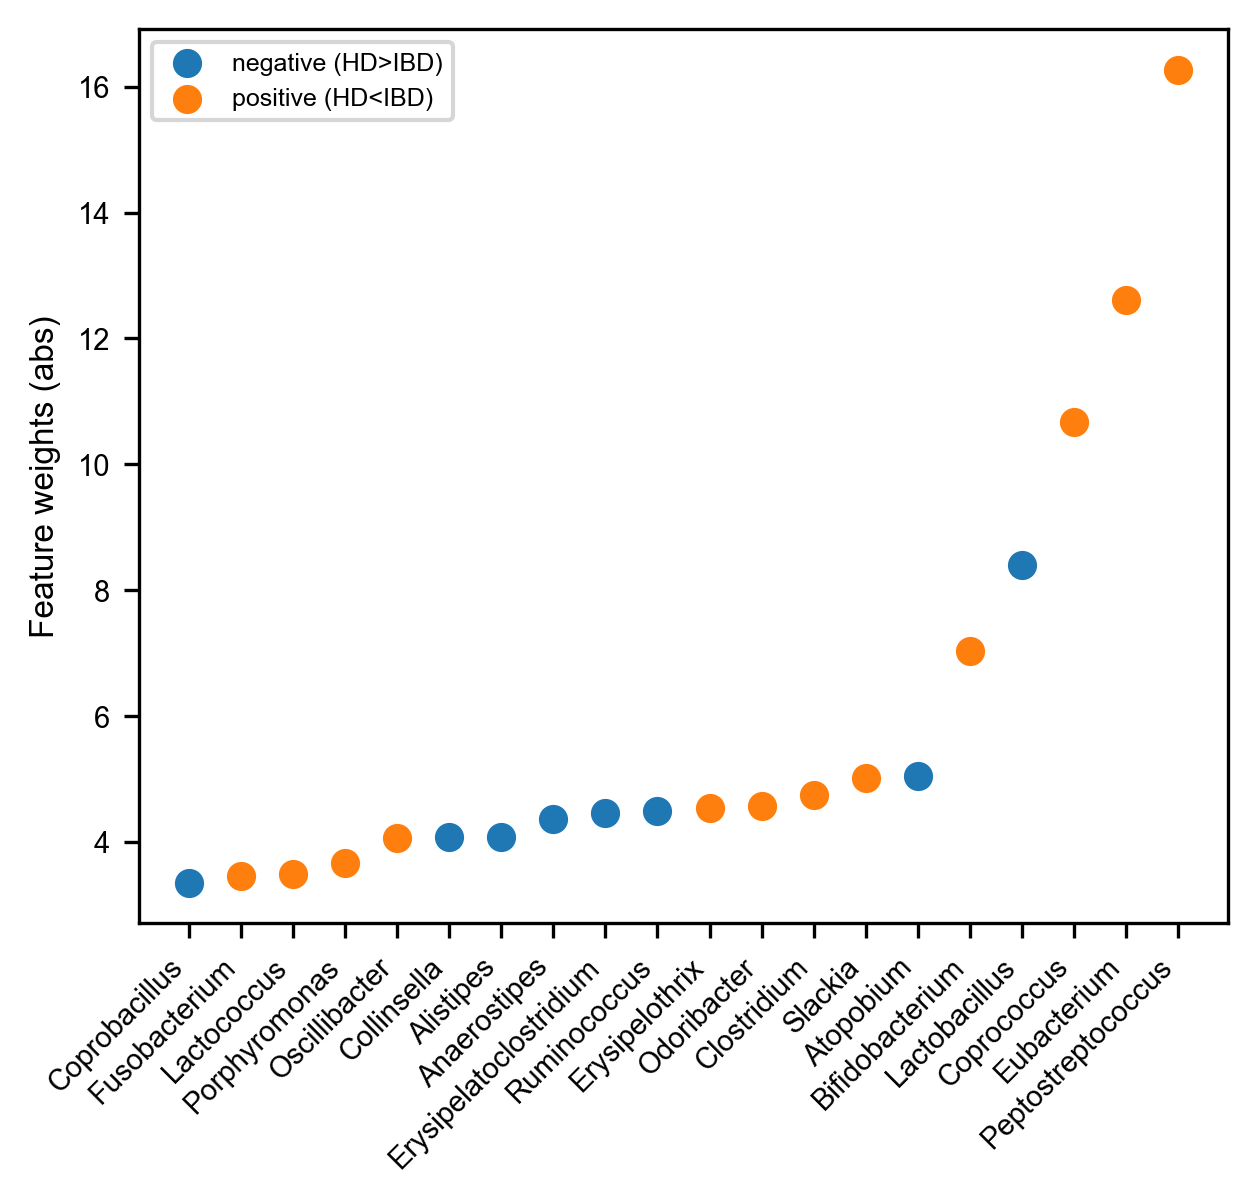

In [17]:
abs_rank = np.abs(mean_weights).argsort()

x_labels = []
pos_y, pos_x, neg_y, neg_x = [], [], [], []
for i, index in enumerate(abs_rank[-20:]):
    x_labels.append(Gevers_HMP2_data.columns.tolist()[index])
    if mean_weights[index] > 0:
        pos_y.append(mean_weights[index])
        pos_x.append(i)
    else:
        neg_y.append(-mean_weights[index])
        neg_x.append(i)

plt.figure(figsize=(4.68,3.87), dpi=300)
plt.scatter(neg_x, neg_y, label='negative (HD>IBD)')
plt.scatter(pos_x, pos_y, label='positive (HD<IBD)')
plt.legend(fontsize=6)
plt.xticks(list(range(len(x_labels))), x_labels, rotation=45, ha='right')
plt.ylabel('Feature weights (abs)', fontdict={'fontsize':8})
plt.tick_params(labelsize=7)
# plt.title('Mean Feature weights (Top20)', fontdict={'fontsize': 9})

plt.savefig('./figures/Gevers_HMP2_feature_rank_1000times.png', dpi=300, bbox_inches='tight')
plt.show()

### Test on GMrepo dataset

In [5]:
# load GMrepo data back
raw_info = pd.read_excel('./RawData/Ours/remove_missing.xlsx', sheet_name='Sheet1', index_col=1)
hd_data = raw_info.iloc[:, 1:314]  # 313 samples
uc_data = raw_info.iloc[:, 317:]  # 299 samples
print(hd_data.shape, uc_data.shape)
GMrepo_data = pd.concat([hd_data, uc_data], axis=1).T
print(GMrepo_data.shape)

GMrepo_data = GMrepo_data.reset_index(drop=True)
# HD as 0, UC as 1
GMrepo_data['label'] = [0] * hd_data.shape[1] + [1] * uc_data.shape[1]
print(GMrepo_data.shape)

(62, 313) (62, 299)
(612, 62)
(612, 63)


In [10]:
len(set(GMrepo_data.columns.tolist()).intersection(Gevers_HMP2_data.columns.tolist()))

42

In [6]:
GMrepo_data_new = np.empty((len(GMrepo_data), Gevers_HMP2_data.shape[1]), dtype=np.float32)
for i, col in enumerate(Gevers_HMP2_data.columns.tolist()):
    if col in GMrepo_data.columns.tolist():
        if col != 'label':
            GMrepo_data_new[:, i] = np.array(GMrepo_data[col].values, dtype=np.float32)
        else:
            # label column no need for multiplying 100
            GMrepo_data_new[:, i] = np.array(GMrepo_data[col].values, dtype=np.int64)
    else:
        GMrepo_data_new[:, i] = np.nan

GMrepo_data_new_df = pd.DataFrame(GMrepo_data_new, columns=Gevers_HMP2_data.columns.tolist(), index=GMrepo_data.index.tolist())
print(GMrepo_data_new_df.shape)

(612, 70)


In [7]:
# using C=10, penalty='l1' as hyperparameters
def classification_final_kfold(all_data, outer_test_data, seed, print_res=True):
    features = all_data.iloc[:, :-1].values
    labels = all_data.iloc[:, -1].values

    # outer X, y
    outer_test_x = outer_test_data.iloc[:, :-1].values
    outer_test_y = outer_test_data.iloc[:, -1].values

    outer_logits_list = []
    # using StratifiedKFold
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    for train_index, test_index in kf.split(features, labels):
        train_x, _ = features[train_index], features[test_index]
        train_y, _ = labels[train_index], labels[test_index]

        scaler = MinMaxScaler(feature_range=(0,1), clip=True)
        pipe = Pipeline([('impute', SimpleImputer(strategy='constant', fill_value=0.)), ('scaler', scaler)])
        X = pipe.fit_transform(train_x)
        outer_X = pipe.transform(outer_test_x)

        model = LogisticRegression(penalty='l1', C=10, solver='liblinear', random_state=seed, max_iter=1000)
        model.fit(X, train_y)
        
        outer_logits = model.predict_proba(outer_X)[:, 1]
        outer_logits_list.append(outer_logits)
        outer_auc = roc_auc_score(outer_test_y, outer_logits)
        if print_res:
            print(outer_auc)

    mean_outer_logits = np.mean(np.stack(outer_logits_list, axis=0), axis=0)
    mean_outer_auc = roc_auc_score(outer_test_y, mean_outer_logits)
    if print_res:
        print('average outer auc:', mean_outer_auc)
    fpr, tpr, _ = roc_curve(outer_test_y, mean_outer_logits)

    return mean_outer_auc, (fpr, tpr)

In [8]:
# one 10-fold cross validation
mean_outer_auc, (fpr, tpr) = classification_final_kfold(Gevers_HMP2_data, GMrepo_data_new_df, seed=42)

0.4733456569822732
0.4589205765758064
0.49408571703334864
0.462051353286247
0.4757070960710355
0.4770106959299903
0.5107867545706134
0.50407642087042
0.45985019286866763
0.4963403036746557
average outer auc: 0.4848429803284644


In [9]:
# 1000 times 10-fold cross validation
from tqdm import tqdm
mean_outer_aucs = []
outer_auc_data = []
for seed in tqdm(np.random.permutation(10000)[:1000]):
    mean_outer_auc, (fpr, tpr) = classification_final_kfold(Gevers_HMP2_data, GMrepo_data_new_df, seed=seed, print_res=False)
    mean_outer_aucs.append(mean_outer_auc)
    outer_auc_data.append((fpr, tpr))
print(np.mean(mean_outer_aucs))

100%|██████████| 1000/1000 [01:19<00:00, 12.61it/s]

0.4745219421500849


### As Outer test

In [18]:
# load GMrepo data back
raw_info = pd.read_excel('./RawData/Ours/remove_missing.xlsx', sheet_name='Sheet1', index_col=1)
hd_data = raw_info.iloc[:, 1:314]  # 313 samples
uc_data = raw_info.iloc[:, 317:]  # 299 samples
print(hd_data.shape, uc_data.shape)
all_data = pd.concat([hd_data, uc_data], axis=1).T
print(all_data.shape)

all_data = all_data.reset_index(drop=True)
# HD as 0, UC as 1
all_data['label'] = [0] * hd_data.shape[1] + [1] * uc_data.shape[1]
print(all_data.shape)

(62, 313) (62, 299)
(612, 62)
(612, 63)


In [19]:
print(len(set(HMP2_data.columns.tolist()).intersection(all_data.columns.tolist())))
print(len(set(Gevers_data.columns.tolist()).intersection(all_data.columns.tolist())))

HMP2_data_new = np.empty((len(HMP2_data), all_data.shape[1]), dtype=np.float32)
for i, col in enumerate(all_data.columns.tolist()):
    if col in HMP2_data.columns.tolist():
        if col != 'label':
            HMP2_data_new[:, i] = np.array(HMP2_data[col].values, dtype=np.float32) * 100
        else:
            HMP2_data_new[:, i] = np.array(HMP2_data[col].values, dtype=np.int64)
    else:
        HMP2_data_new[:, i] = np.nan

HMP2_data_new_df = pd.DataFrame(HMP2_data_new, columns=all_data.columns.tolist(), index=HMP2_data.index.tolist())
print(HMP2_data_new_df.shape)

Gevers_data_new = np.empty((len(Gevers_data), all_data.shape[1]), dtype=np.float32)
for i, col in enumerate(all_data.columns.tolist()):
    if col in Gevers_data.columns.tolist():
        if col != 'label':
            Gevers_data_new[:, i] = np.array(Gevers_data[col].values, dtype=np.float32)
        else:
            # label column no need for multiplying 100
            Gevers_data_new[:, i] = np.array(Gevers_data[col].values, dtype=np.int64)
    else:
        Gevers_data_new[:, i] = np.nan

Gevers_data_new_df = pd.DataFrame(Gevers_data_new, columns=all_data.columns.tolist(), index=Gevers_data.index.tolist())
print(Gevers_data_new_df.shape)

Gevers_HMP2_data_new_df = pd.concat([HMP2_data_new_df, Gevers_data_new_df], axis=0)
print(Gevers_HMP2_data_new_df.shape)

36
42
(139, 63)
(426, 63)
(565, 63)


In [20]:
# using C=10, penalty='l1' as hyperparameters
def classification_final_kfold(all_data, outer_test_data, seed, print_res=True):
    features = all_data.iloc[:, :-1].values
    labels = all_data.iloc[:, -1].values

    # outer X, y
    outer_test_x = outer_test_data.iloc[:, :-1].values
    outer_test_y = outer_test_data.iloc[:, -1].values

    outer_logits_list = []
    # using KFold
    kf = KFold(n_splits=10, shuffle=True, random_state=seed)
    for train_index, test_index in kf.split(features):
        train_x, _ = features[train_index], features[test_index]
        train_y, _ = labels[train_index], labels[test_index]

        scaler = MinMaxScaler(feature_range=(0,1), clip=True)
        pipe = Pipeline([('impute', SimpleImputer(strategy='constant', fill_value=0.)), ('scaler', scaler)])
        X = pipe.fit_transform(train_x)
        outer_X = pipe.transform(outer_test_x)

        model = LogisticRegression(penalty='l1', C=10, solver='liblinear', random_state=seed, max_iter=1000)
        model.fit(X, train_y)
        
        outer_logits = model.predict_proba(outer_X)[:, 1]
        outer_logits_list.append(outer_logits)
        outer_auc = roc_auc_score(outer_test_y, outer_logits)
        if print_res:
            print(outer_auc)

    mean_outer_logits = np.mean(np.stack(outer_logits_list, axis=0), axis=0)
    mean_outer_auc = roc_auc_score(outer_test_y, mean_outer_logits)
    if print_res:
        print('average outer auc:', mean_outer_auc)
    fpr, tpr, _ = roc_curve(outer_test_y, mean_outer_logits)

    return mean_outer_auc, (fpr, tpr)

In [21]:
# one 10-fold cross validation
mean_outer_auc, (fpr, tpr) = classification_final_kfold(all_data, Gevers_HMP2_data_new_df, seed=42)

0.5465979381443299
0.5464432989690722
0.5705927835051547
0.5570103092783505
0.578221649484536
0.5333505154639175
0.5365206185567011
0.5431958762886597
0.5804639175257732
0.553762886597938
average outer auc: 0.5573453608247423


In [22]:
# 1000 times 10-fold cross validation
from tqdm import tqdm
mean_outer_aucs = []
outer_auc_data = []
for seed in tqdm(np.random.permutation(10000)[:1000]):
    mean_outer_auc, (fpr, tpr) = classification_final_kfold(all_data, Gevers_HMP2_data_new_df, seed=seed, print_res=False)
    mean_outer_aucs.append(mean_outer_auc)
    outer_auc_data.append((fpr, tpr))
print(np.mean(mean_outer_aucs))

100%|██████████| 1000/1000 [04:12<00:00,  3.96it/s]

0.5565668298969072
